# Multi Agents

In [50]:
from dotenv import load_dotenv
load_dotenv()

True

In [51]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [52]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [53]:
llm.invoke("hi hello how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 13, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bx27X5SrgHJ2xI2T83bHIfcGZWmqL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--cb2f9d82-1822-49c1-b9a7-56aa519dccd8-0', usage_metadata={'input_tokens': 13, 'output_tokens': 27, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### In Built Classes to connect agents, and create react agent

In [54]:
from langgraph.types import Command

In [55]:
from langgraph.prebuilt import create_react_agent

### Example: Function using Command

In [56]:
def add_number(state):
    result = state["num1"] + state["num2"]
    print(f"Addition is {result}")

    return Command(goto="multiply", update = {"sum": result})

In [57]:
state = {"num1": 10, "num2": 20}

In [58]:
add_number(state)

Addition is 30


Command(update={'sum': 30}, goto='multiply')

## Network/Collaborative Agent

### Creating one dummy multiagent

In [59]:
from langchain_core.tools import tool

In [60]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [61]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [62]:
llm_with_tool = llm.bind_tools([transfer_to_multiplication_expert])

g:\AgenticAI\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
g:\AgenticAI\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
g:\AgenticAI\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Gui

In [63]:
response = llm_with_tool.invoke("hi")

In [64]:
response.content

'Hello! How can I assist you today?'

In [65]:
response.tool_calls

[]

In [66]:
response = llm_with_tool.invoke("what is 2 * 2?")

In [67]:
response.content

''

In [68]:
response.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_Rf133QVKdrJDlxbf7mBFTfxl',
  'type': 'tool_call'}]

### Creating StateGraph, and Using Command in the functions

In [69]:
from langchain_core.tools import tool

@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [70]:
SYSTEM_PROMPT = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

messages = [{"role": "system", "content": SYSTEM_PROMPT}] + ["Can you tell me the addition of 2 and 2 ?"]

messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'Can you tell me the addition of 2 and 2 ?']

In [71]:
llm_with_tool.invoke(messages)

AIMessage(content='The addition of 2 and 2 is 4.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 83, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bx27Z7RPzgyED8jSpBoYLcKg6f9ju', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--eb1a8b13-4eed-438a-8cae-7f608fe7e578-0', usage_metadata={'input_tokens': 83, 'output_tokens': 13, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [72]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [73]:
def additional_expert(state: MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    SYSTEM_PROMPT = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": SYSTEM_PROMPT}] + state["messages"]
    llm_with_tool = llm.bind_tools([transfer_to_multiplication_expert])

    ai_msg = llm_with_tool.invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]

        # Meta Info
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }

        return Command(
            goto = "multiplication_expert",
            update = {"messages": [ai_msg, tool_msg]}
        )

    return {"messages": [ai_msg]}

In [74]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    SYSTEM_PROMPT = (
        "You are an multiplication expert, you can ask the addition expert for help with addition."
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": SYSTEM_PROMPT}] + state["messages"]
    llm_with_tool = llm.bind_tools([transfer_to_addition_expert])

    ai_msg = llm_with_tool.invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]

        # Meta Info
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }

        return Command(
            goto = "additional_expert",
            update = {"messages": [ai_msg, tool_msg]}
        )

    return {"messages": [ai_msg]} 

In [75]:
graph = StateGraph(MessagesState)

In [76]:
graph.add_node("additional_expert", additional_expert)

In [77]:
graph.add_node("multiplication_expert", multiplication_expert)

In [78]:
graph.add_edge(START, "additional_expert")

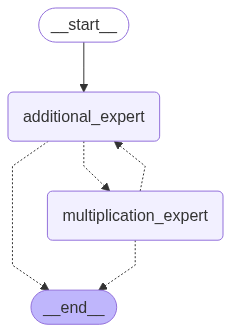

In [79]:
app = graph.compile()
app

In [80]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

g:\AgenticAI\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
g:\AgenticAI\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
g:\AgenticAI\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Gui

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='45a2635b-f4a3-4877-b98e-022e2867f143'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9FBdiR3U9LFzsECjox8yGGBV', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 86, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bx27aS2AyQWY2ACPqj4EzZ9enmJ8D', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b7de21e7-f06f-4717-ab43-22372183b83f-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 

### Realtime Tool Implementation

In [81]:
# from langchain_community.tools import DuckDuckGoSearchRun

# search_tool=DuckDuckGoSearchRun()

In [82]:
import os
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [83]:
from langchain_tavily import TavilySearch

search_tool=TavilySearch(tavily_api_key=TAVILY_API_KEY)

In [84]:
search_tool.invoke("who is India current Vice President?")

{'query': 'who is India current Vice President?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/List_of_vice_presidents_of_India',
   'title': 'List of vice presidents of India - Wikipedia',
   'content': "Jagdeep Dhankhar  Elected as the vice president in 2022 defeating his rival candidate Margaret Alva of the Indian National Congress. First vice president to be born after India's becoming a republic in 1950.",
   'score': 0.8506799,
   'raw_content': None},
  {'url': 'https://vicepresidentofindia.nic.in/',
   'title': 'Home | Vice President of India | Government of India',
   'content': "The Vice-President, Shri Jagdeep Dhankhar addressing the gathering at 'Sneh Milan Samaroh' in Jaipur, Rajathan on June 30, 2025.",
   'score': 0.82186085,
   'raw_content': None},
  {'url': 'https://x.com/vpindia?lang=en',
   'title': 'Vice-President of India (@VPIndia) / X',
   'content': "Hon'ble Vice-President of India & Chairman,

In [85]:
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

In [86]:
code = """
x = 5
y = x * 2
print(y)
"""

In [87]:
repl.run(code)

'10\n'

In [88]:
from typing import Annotated

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
    ):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
        
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:16: SyntaxWarning: invalid escape sequence '\`'
<>:16: SyntaxWarning: invalid escape sequence '\`'
<>:16: SyntaxWarning: invalid escape sequence '\`'
<>:16: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Harshit\AppData\Local\Temp\ipykernel_21708\895088054.py:16: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Harshit\AppData\Local\Temp\ipykernel_21708\895088054.py:16: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [89]:
print(python_repl_tool.invoke(code))


Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [90]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [91]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [92]:
from langchain_core.messages import BaseMessage, HumanMessage


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message:
        return END
    
    return goto

In [93]:
# Agent 1

def research_node(state: MessagesState)-> Command[Literal["chart_generator", END]]:
    research_agent = create_react_agent(
        llm,
        tools = [search_tool],
        prompt = make_system_prompt(
            "You can only do research. You are working with a chart generator colleague."
        ),
    )

    result = research_agent.invoke(state)

    last_message = result["messages"][-1]

    goto=get_next_node(last_message,"chart_generator")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")

    return Command(update= {"messages": result["messages"]}, goto = goto)

In [94]:
# Agent 2

def chart_node(state: MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent = create_react_agent(
        llm,
        tools = [python_repl_tool],
        prompt = make_system_prompt(
            "You can only generate charts. You are working with a researcher colleague."
        ),
    )

    result = chart_agent.invoke(state)

    last_message = result["messages"][-1]

    goto=get_next_node(last_message,"researcher")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")

    return Command(update= {"messages": result["messages"]}, goto= goto)

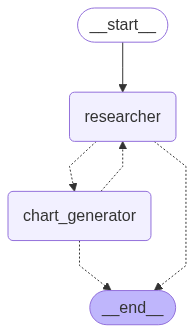

In [95]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")

app = workflow.compile()

app

In [97]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

KeyboardInterrupt: 